<a href="https://colab.research.google.com/github/gopal2812/mlblr/blob/master/capastone_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer based model to translate English text to Python code

The goal is to  write a transformer-based model that can translats English text to python code(with proper whitespace indentations)

The training dataset contains around 4600+ examples of English text to python code. 
- must use transformers with self-attention, multi-head, and scaled-dot product attention in the model
- There is no limit on the number of training epochs or total number of parameters in the model
- should have trained a separate embedding layer for python keywords and paid special attention to whitespaces, colon and other things (like comma etc)
- model should to do proper indentation
- model should to use newline properly
- model should understand how to use colon (:)
- model should generate proper python code that can run on a Python interpreter and produce proper results


Some preprocessing checks on the dataset should be carried out like:
 - the dataset provided is divided into English and "python-code" pairs properly
the dataset does not have anomalies w.r.t. indentations (like a mixed-use of tabs and spaces, or use of either 4 or 3 spaces, it should be 4 spaces only). Either use tabs only or 4 spaces only, not both
- the length of the "python-code" generated is not out of your model's capacity


In [ ]:
!pip install torchtext==0.8.1


In [ ]:
import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import pandas as pd
import numpy as np

from torchtext.data import Field, BucketIterator, LabelField, TabularDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l drive/MyDrive/

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    # if n_gpu > 0:
    #     torch.cuda.manual_seed_all(seed)
set_seed(0x1882299)

total 3347551
-rw------- 1 root root      83296 Apr 21  2014  13033148255_BVRxxxxx9Q_A1.zip
drwx------ 2 root root       4096 Jul 26  2014 '13033148255_BVRxxxxx9Q_A1.zip (Unzipped Files)'
-rw------- 1 root root        151 Sep  3  2013 '20130901  po_paymentdetails members 33 to 40.gsheet'
-rw------- 1 root root      31354 Jul  9  2017  20170707_OrderTrades_25068.pdf
-rw------- 1 root root      54690 Dec 16  2013 'A82542 dec.pdf'
-rw------- 1 root root      54576 Dec 16  2013 'A82542 jan.pdf'
-rw------- 1 root root        151 Sep  2  2013 'additional information on demant letters.gsheet'
-rw------- 1 root root    1946179 Mar 11 05:59  ag_news.test
-rw------- 1 root root   30877815 Mar 11 05:59  ag_news.train
-rw------- 1 root root     534516 Dec 16  2013 'Aircel P 2 Offer Letter.pdf'
-rw------- 1 root root     771981 Dec 16  2013 'Aircel page 1.pdf'
-rw------- 1 root root        151 Jul 22  2012  Amit_Cv_sample.doc.gdoc
-rw------- 1 root root     313338 Apr  4  2017  aonla2.jpg
-rw------

Now to set the results in a processable format, we will set the random seed values, Please note that the random seed values only gaurantee results in same runtime, results may vary after runtime is refreshed.

In [ ]:
datasets = [[]]
file_name = '/content/drive/MyDrive/clean_data_10k.py'

with open(file_name) as f:
  for line in f:
    if line.startswith('#'):
      comment = line.split('\n#')
      if datasets[-1] != []:
        # we are in a new block
        datasets.append(comment)
    else:
      stripped_line = line#.strip()
      if stripped_line:
        datasets[-1].append(stripped_line)       

In [ ]:
# Divide the data into Description and code
raw_data = {'Description' : [re.sub(r"^#(\d)*",'',x[0]).strip() for x in datasets], 'Code': [''.join(x[1:]) for x in datasets]}
df = pd.DataFrame(raw_data, columns=["Description", "Code"])

In [ ]:
df['Description'][0]

''

In [ ]:
df.head()

,Description,Code
0,,
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...
2,write a python function to add two user provid...,"\ndef add_two_numbers(num1, num2):\n sum = ..."
3,write a program to find and print the largest ...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >=...
4,write a program to find and print the smallest...,\nnum1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <=...


In [ ]:
df['Code'].replace("", float("NaN"), inplace=True)

In [ ]:
df[df.isna().any(axis=1)]

,Description,Code
0,,NaN


In [ ]:
df.dropna(subset = ["Code"], inplace=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4492 entries, 1 to 4492
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  4492 non-null   object
 1   Code         4492 non-null   object
dtypes: object(2)
memory usage: 105.3+ KB


In [ ]:
df['CodeLen'] = df['Code'].astype(str).map(len)
MAX_LENGTH = 350
Q_MAX_LENGTH = MAX_LENGTH - 5

In [ ]:
df.size

13476

In [ ]:
MAX_LENGTH = 350
Q_MAX_LENGTH = MAX_LENGTH - 5

In [ ]:
df = df[df['CodeLen'] < Q_MAX_LENGTH] 
df.size
df.head(2)

,Description,Code,CodeLen
1,write a python program to add two numbers,\nnum1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\np...,63
2,write a python function to add two user provid...,"\ndef add_two_numbers(num1, num2):\n sum = ...",72


In [ ]:
# Dividing the data into train and validation dataset
train_df = df.sample(frac = 0.80) 
  
# Creating dataframe with rest of the 20% values 
valid_df = df.drop(train_df.index)

In [ ]:
print(f'train df {train_df}')
print(f'Valid df {valid_df}')

train_df.to_csv('train.csv', index=False)
valid_df.to_csv('valid.csv', index=False)

train df                                             Description  ... CodeLen
4274  write Python code t get difference of two list...  ...     172
3086  Write a Python Program to Check if a Number is...  ...     168
4161    17 write a function to initialize a linked list  ...     162
3886  Please write a program to shuffle and print th...  ...      68
4376  Write a program that accepts a sentence and ca...  ...     265
...                                                 ...  ...     ...
541   Write a python Program to Flatten and print a ...  ...     142
1558  write a Python function to return the volume o...  ...     132
2539  write a python function that takes a dictionar...  ...     156
3282  Write a Python program to convert two equal le...  ...     113
4275             write a program for round for integers  ...      64

[3308 rows x 3 columns]
Valid df                                             Description  ... CodeLen
10    Write a program to print the multiplication ta...  ...

In [ ]:
'''
ENDMARKER = 0
NAME = 1
NUMBER = 2
STRING = 3
NEWLINE = 4
INDENT = 5
DEDENT = 6
LPAR = 7
RPAR = 8
LSQB = 9
RSQB = 10
COLON = 11
COMMA = 12
SEMI = 13
PLUS = 14
MINUS = 15
STAR = 16
SLASH = 17
VBAR = 18
AMPER = 19
LESS = 20
GREATER = 21
EQUAL = 22
DOT = 23
PERCENT = 24
LBRACE = 25
RBRACE = 26
EQEQUAL = 27
NOTEQUAL = 28
LESSEQUAL = 29
GREATEREQUAL = 30
TILDE = 31
CIRCUMFLEX = 32
LEFTSHIFT = 33
RIGHTSHIFT = 34
DOUBLESTAR = 35
PLUSEQUAL = 36
MINEQUAL = 37
STAREQUAL = 38
SLASHEQUAL = 39
PERCENTEQUAL = 40
AMPEREQUAL = 41
VBAREQUAL = 42
CIRCUMFLEXEQUAL = 43
LEFTSHIFTEQUAL = 44
RIGHTSHIFTEQUAL = 45
DOUBLESTAREQUAL = 46
DOUBLESLASH = 47
DOUBLESLASHEQUAL = 48
AT = 49
ATEQUAL = 50
RARROW = 51
ELLIPSIS = 52
COLONEQUAL = 53
OP = 54
AWAIT = 55
ASYNC = 56
TYPE_IGNORE = 57
TYPE_COMMENT = 58
# These aren't used by the C tokenizer but are needed for tokenize.py
ERRORTOKEN = 59
COMMENT = 60
NL = 61
ENCODING = 62
N_TOKENS = 63
# Special definitions for cooperation with parser
NT_OFFSET = 256
'''

"\nENDMARKER = 0\nNAME = 1\nNUMBER = 2\nSTRING = 3\nNEWLINE = 4\nINDENT = 5\nDEDENT = 6\nLPAR = 7\nRPAR = 8\nLSQB = 9\nRSQB = 10\nCOLON = 11\nCOMMA = 12\nSEMI = 13\nPLUS = 14\nMINUS = 15\nSTAR = 16\nSLASH = 17\nVBAR = 18\nAMPER = 19\nLESS = 20\nGREATER = 21\nEQUAL = 22\nDOT = 23\nPERCENT = 24\nLBRACE = 25\nRBRACE = 26\nEQEQUAL = 27\nNOTEQUAL = 28\nLESSEQUAL = 29\nGREATEREQUAL = 30\nTILDE = 31\nCIRCUMFLEX = 32\nLEFTSHIFT = 33\nRIGHTSHIFT = 34\nDOUBLESTAR = 35\nPLUSEQUAL = 36\nMINEQUAL = 37\nSTAREQUAL = 38\nSLASHEQUAL = 39\nPERCENTEQUAL = 40\nAMPEREQUAL = 41\nVBAREQUAL = 42\nCIRCUMFLEXEQUAL = 43\nLEFTSHIFTEQUAL = 44\nRIGHTSHIFTEQUAL = 45\nDOUBLESTAREQUAL = 46\nDOUBLESLASH = 47\nDOUBLESLASHEQUAL = 48\nAT = 49\nATEQUAL = 50\nRARROW = 51\nELLIPSIS = 52\nCOLONEQUAL = 53\nOP = 54\nAWAIT = 55\nASYNC = 56\nTYPE_IGNORE = 57\nTYPE_COMMENT = 58\n# These aren't used by the C tokenizer but are needed for tokenize.py\nERRORTOKEN = 59\nCOMMENT = 60\nNL = 61\nENCODING = 62\nN_TOKENS = 63\n# Special def

In [ ]:
import io
from io import BytesIO
from tokenize import tokenize, untokenize, NUMBER, STRING, NAME, OP, tok_name
#https://docs.python.org/3/library/tokenize.html
def tokenize_python(code_snippet):
    tokens = tokenize(io.BytesIO(code_snippet.encode('utf-8')).readline)
    parsed = []
    for token in tokens:
        if token.type not in [0,59,60,61,62,63,256]:
            parsed.append(token.string)
    return parsed

In [ ]:
tokenize_python(df['Code'][24])

['utf-8',
 '\n',
 'def',
 'lcm',
 '(',
 'a',
 ',',
 'b',
 ')',
 ':',
 '\n',
 '    ',
 'if',
 'a',
 '>',
 'b',
 ':',
 '\n',
 '        ',
 'min_',
 '=',
 'a',
 '\n',
 '',
 'else',
 ':',
 '\n',
 '        ',
 'min_',
 '=',
 'b',
 '\n',
 '',
 'while',
 'True',
 ':',
 '\n',
 '        ',
 'if',
 'min_',
 '%',
 'a',
 '==',
 '0',
 'and',
 'min_',
 '%',
 'b',
 '==',
 '0',
 ':',
 '\n',
 '            ',
 'break',
 '\n',
 '',
 'min_',
 '+=',
 '1',
 '\n',
 '',
 'return',
 'min_',
 '\n',
 '\n',
 '']

In [ ]:
import re
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    infix_re = re.compile(r'''[.\,\?\:\;\...\‘\’\`\“\”\"\'\(\)\[\]\{\}\*\%\^\+\-\=\<\>\|\!(//)(\n)(\t)~]''')
    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    return Tokenizer(nlp.vocab, prefix_search=prefix_re.search,
                                suffix_search=suffix_re.search,
                                infix_finditer=infix_re.finditer,
                                token_match=None)

In [ ]:
import spacy
!pip install -U spacy
!python3 -m spacy download en_core_web_trf
#spacy_en = spacy.load('en')
spacy_en = spacy.load('en_core_web_trf')

spacy_code = spacy.load('en_core_web_trf')
spacy_code.tokenizer = custom_tokenizer(spacy_code)


def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_code(text):
    """
    Tokenizes Code text from a string into a list of strings
    """
    return [tok.text for tok in spacy_code.tokenizer(text)]

SRC = Field(tokenize= tokenize_en, 
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=True,
            batch_first=True)

#TRG = Field(tokenize = tokenize_python,
TRG = Field(tokenize = tokenize_code,  
            init_token='<sos>', 
            eos_token='<eos>', 
            lower=False,
            batch_first=True)

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.5)
2021-03-20 18:13:39.353820: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [ ]:
fields = [('Description', SRC),('Code',TRG)]



In [ ]:
# Using tabular dataset to process the text

train_data, test_data = TabularDataset.splits(
                                path = '',   
                                train = './train.csv',
                                test = './valid.csv',
                                format = 'csv',
                                fields = fields)

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [ ]:
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#SRC.build_vocab(train_data, min_freq = 2,max_size= 10000)
#TRG.build_vocab(test_data, min_freq = 2,max_size= 10000)

SRC.build_vocab(train_data, min_freq = 1)
TRG.build_vocab(test_data, min_freq = 1)


After building a vocab, next step is creating a bucket iterator. A bucket iterator helps us to batch together sentence of similar lengths.

In [ ]:
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.Description),
    device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)



Now its time to build a connection for our data in model, it will travel from encoder to decoder. This class will take the below params

Encoder Object
Encoder Mask
Decoder Object
Decoder Mask
Device
Dropout Value
First we will create mask for our data,

But why we need mask??
We need mask because ......

After this we will cal

'SRC' which is also our source sentence is sent to encoder along with the

'TRG' would be sent to our decoder, along with encoder outputs which is also our generated attention

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]


        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]        
        return output, attention

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = MAX_LENGTH):
        super().__init__()

        self.device = device
        # below we are breaking down the embedding into input and positional embedding
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
         # We also add layers for multi-headed processing
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        # We also add a dropout value for regularization
        self.dropout = nn.Dropout(dropout)
        # When we add two embeddings, we multiply our embeddings with a scale parameter, which helps us to maintain
        # our values in a certain range
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
 
            
        return src

Encoder Layer - This layer creates the multiple encoder layer which consists of Pointwise Feed forward and multi-headed attention networks, the code is mentioned below. This layer basically calls attention layer and pointwise layers and also applies a norm to their outputs

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

Scaled Dot-product attention -
In scaled dot product attention query and key via matrix multiplication, after this the output is scaled, masked and softmax is applied to it. This attenion is then multiplied with the value to get contextual information.

Multi-Head Attention
Why we call it as multi-head is it takes data into 3 forms Key, Query and the Value. Doing a matrix multiplication of Key with Query gives us attention values, these attention values are then multiplied by the Value which gives us contextualized embeddings.

Each embedding is divided into certain heads (which is also knows as n-heads), the total hid dim are divided into n-heads, these n-heads then act as the channels which contains relevant info.

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x


Now comes the decoder part, the decoder takes encoder outputs and the target sentece to generate train the network and generate the outputs.

The decoder components are mostly similar to the encoder, although there are a few necessary changes that are done.

Starting from below we can see the same embeddings (target and the positional embeddings are applied.

These embeddings are then sent to masekd multi-head attention blocks, these blocks and theoutputs are then added with the residual outputs and then noramalized using batch norm (known as layer norm here).

Now these outputs are again sent the Multi-headed attention block along with the encoder outputs, this block generates a relationship between Source coming from encoder and the Target values.

Then these values are again added with the residual outputs and sent to linear layer. Finally softmax is applied to the results

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = MAX_LENGTH):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 512
# ENC_LAYERS = 2
ENC_LAYERS = 3
#DEC_LAYERS = 2
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)


dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT,
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 19,149,749 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [ ]:
model.apply(initialize_weights);


In [ ]:

LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=500, epochs=25)
#scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-8,verbose=True)
#lrs = []

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.Description
        trg = batch.Code
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])

                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]

            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        #loss = maskNLLLoss(output, trg,model.trg_pad_idx)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Use optimizer.step() before scheduler.step(). Also, for OneCycleLR, you need to run scheduler.step() after every step - source (PyTorch docs). 
        # (as far as calling step() on optimizer and schedulers is concerned).
        
        optimizer.step()
        #if(scheduler is not None):
        #    scheduler.step(valid_loss)
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.Description
            trg = batch.Code

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
           
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            
            loss = criterion(output, trg)
            #loss = maskNLLLoss(output, trg,model.trg_pad_idx)

            #loss,_ = maskNLLLoss(output, trg, mask)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save({"model":model.state_dict(),
                "optimizer":optimizer.state_dict(),
                "loss":valid_loss,
                }, 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 14s
	Train Loss: 3.964 | Train PPL:  52.666
	 Val. Loss: 3.267 |  Val. PPL:  26.220
Epoch: 02 | Time: 0m 14s
	Train Loss: 2.632 | Train PPL:  13.905
	 Val. Loss: 2.687 |  Val. PPL:  14.688
Epoch: 03 | Time: 0m 13s
	Train Loss: 2.218 | Train PPL:   9.189
	 Val. Loss: 2.398 |  Val. PPL:  11.000
Epoch: 04 | Time: 0m 13s
	Train Loss: 1.962 | Train PPL:   7.112
	 Val. Loss: 2.174 |  Val. PPL:   8.792
Epoch: 05 | Time: 0m 13s
	Train Loss: 1.758 | Train PPL:   5.802
	 Val. Loss: 2.029 |  Val. PPL:   7.603
Epoch: 06 | Time: 0m 13s
	Train Loss: 1.611 | Train PPL:   5.009
	 Val. Loss: 1.909 |  Val. PPL:   6.747
Epoch: 07 | Time: 0m 13s
	Train Loss: 1.484 | Train PPL:   4.412
	 Val. Loss: 1.828 |  Val. PPL:   6.222
Epoch: 08 | Time: 0m 13s
	Train Loss: 1.378 | Train PPL:   3.966
	 Val. Loss: 1.755 |  Val. PPL:   5.786
Epoch: 09 | Time: 0m 13s
	Train Loss: 1.285 | Train PPL:   3.614
	 Val. Loss: 1.711 |  Val. PPL:   5.534
Epoch: 10 | Time: 0m 13s
	Train Loss: 1.200 | Train PPL

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):

    model.eval()
        
    if isinstance(sentence, str):
        #nlp = spacy.load('en')
        nlp = spacy.load('en_core_web_trf')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor,src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
        
    fig = plt.figure(figsize=(15,35))

    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        if isinstance(sentence, str):
        #nlp = spacy.load('en')
          nlp = spacy.load('en_core_web_trf')
          tokens = [token.text.lower() for token in nlp(sentence)]
        else:
          tokens = [token.lower() for token in sentence]

        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in tokens]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
import time
import math

def run_train_eval_loop(model, 
                        train_dataloader,
                        val_dataloader,
                        optimizer,
                        criterion,
                        device,
                        epochs=20,
                        clip=1,
                        best_valid_loss=float('inf'),
                        file_path='tut6-model.pt',
                        scheduler=None):
    
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
    
    for epoch in range(epochs):
    
        start_time = time.time()
        
        train_loss = train(model, train_dataloader, optimizer, criterion, clip)
        valid_loss = evaluate(model, val_dataloader, criterion)
        
        if(scheduler is not None):
            scheduler.step(valid_loss)
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({"model":model.state_dict(),
                        "optimizer":optimizer.state_dict(),
                        "loss":valid_loss,
                       },file_path)
        
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
#!pwd
#!ls -l /content/drive/MyDrive/

In [ ]:
!cp /content/tut6-model.pt /content/drive/MyDrive/tut6-model.pt
file_path='/content/tut6-model.pt'
chkpt = torch.load(file_path)
model.load_state_dict(chkpt['model'])
file_path='/content/tut6-model.pt'
LEARNING_RATE = 0.00005
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
run_train_eval_loop(model,
                    train_iterator,
                    test_iterator,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path)

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 13s
	Train Loss: 0.583 | Train PPL:   1.792
	 Val. Loss: 1.446 |  Val. PPL:   4.244
Epoch: 02 | Time: 0m 13s
	Train Loss: 0.530 | Train PPL:   1.698
	 Val. Loss: 1.440 |  Val. PPL:   4.221
Epoch: 03 | Time: 0m 13s
	Train Loss: 0.513 | Train PPL:   1.671
	 Val. Loss: 1.442 |  Val. PPL:   4.229
Epoch: 04 | Time: 0m 13s
	Train Loss: 0.497 | Train PPL:   1.643
	 Val. Loss: 1.441 |  Val. PPL:   4.224
Epoch: 05 | Time: 0m 13s
	Train Loss: 0.483 | Train PPL:   1.621
	 Val. Loss: 1.448 |  Val. PPL:   4.256
Epoch: 06 | Time: 0m 13s
	Train Loss: 0.472 | Train PPL:   1.604
	 Val. Loss: 1.448 |  Val. PPL:   4.257
Epoch: 07 | Time: 0m 13s
	Train Loss: 0.465 | Train PPL:   1.592
	 Val. Loss: 1.452 |  Val. PPL:   4.271
Epoch: 08 | Time: 0m 13s
	Train Loss: 0.452 | Train PPL:   1.572
	 Val. Loss: 1.459 |  Val. PPL:   4.302
Epoch: 09 | Time: 0m 13s
	Train Loss: 0.446 | Train PPL:   1.562
	 Val. Loss: 1.459 |  Val. PPL:   4.303
Epoch: 10 | Time: 0m 13s
	Train Loss: 0.440 | Train PPL

In [ ]:
file_path='/content/tut6-model.pt'
chkpt = torch.load(file_path)
print(chkpt['loss'])
model.load_state_dict(chkpt['model'])
file_path='/content/tut6-model.pt'
LEARNING_RATE = 0.00001
scheduler = ReduceLROnPlateau(optimizer, patience=5, min_lr=1e-9,verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
run_train_eval_loop(model,
                    train_iterator,
                    test_iterator,
                    optimizer,
                    criterion,
                    device,
                    epochs=100,
                    clip=1,
                    best_valid_loss=float('inf'),
                    file_path=file_path)

!cp /content/tut6-model.pt /content/drive/MyDrive/tut6-model.pt

1.4399619790223928


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 13s
	Train Loss: 0.513 | Train PPL:   1.670
	 Val. Loss: 1.438 |  Val. PPL:   4.213
Epoch: 02 | Time: 0m 13s
	Train Loss: 0.502 | Train PPL:   1.652
	 Val. Loss: 1.438 |  Val. PPL:   4.214
Epoch: 03 | Time: 0m 13s
	Train Loss: 0.498 | Train PPL:   1.646
	 Val. Loss: 1.437 |  Val. PPL:   4.206
Epoch: 04 | Time: 0m 13s
	Train Loss: 0.497 | Train PPL:   1.644
	 Val. Loss: 1.437 |  Val. PPL:   4.209
Epoch: 05 | Time: 0m 13s
	Train Loss: 0.490 | Train PPL:   1.633
	 Val. Loss: 1.439 |  Val. PPL:   4.217
Epoch: 06 | Time: 0m 13s
	Train Loss: 0.491 | Train PPL:   1.634
	 Val. Loss: 1.438 |  Val. PPL:   4.214
Epoch: 07 | Time: 0m 13s
	Train Loss: 0.482 | Train PPL:   1.620
	 Val. Loss: 1.439 |  Val. PPL:   4.217
Epoch: 08 | Time: 0m 13s
	Train Loss: 0.484 | Train PPL:   1.623
	 Val. Loss: 1.440 |  Val. PPL:   4.222
Epoch: 09 | Time: 0m 13s
	Train Loss: 0.480 | Train PPL:   1.615
	 Val. Loss: 1.439 |  Val. PPL:   4.215
Epoch: 10 | Time: 0m 13s
	Train Loss: 0.478 | Train PPL

predicted trg = ['num1', '=', '10', '\n', 'num2', '=', '14', '\n', 'num3', '=', '12', '\n', 'if', '(', 'num1', '>', '=', 'num2', ')', 'and', '(', 'num1', '>', '=', 'num3', ')', ':', '\n    ', 'largest', '=', 'num1', '\n', 'elif', '(', 'num2', '>', '=', 'num3', ')', 'and', '(', 'num2', '>', '=', 'num3', ')', ':', '\n    ', 'largest', '=', 'num1', '\n', 'else', ':', '\n    ', 'largest', '=', 'num3', '\n', 'print', '(', 'f', "'", 'largest', ':', '{', 'largest', '}', "'", ')', '<eos>']


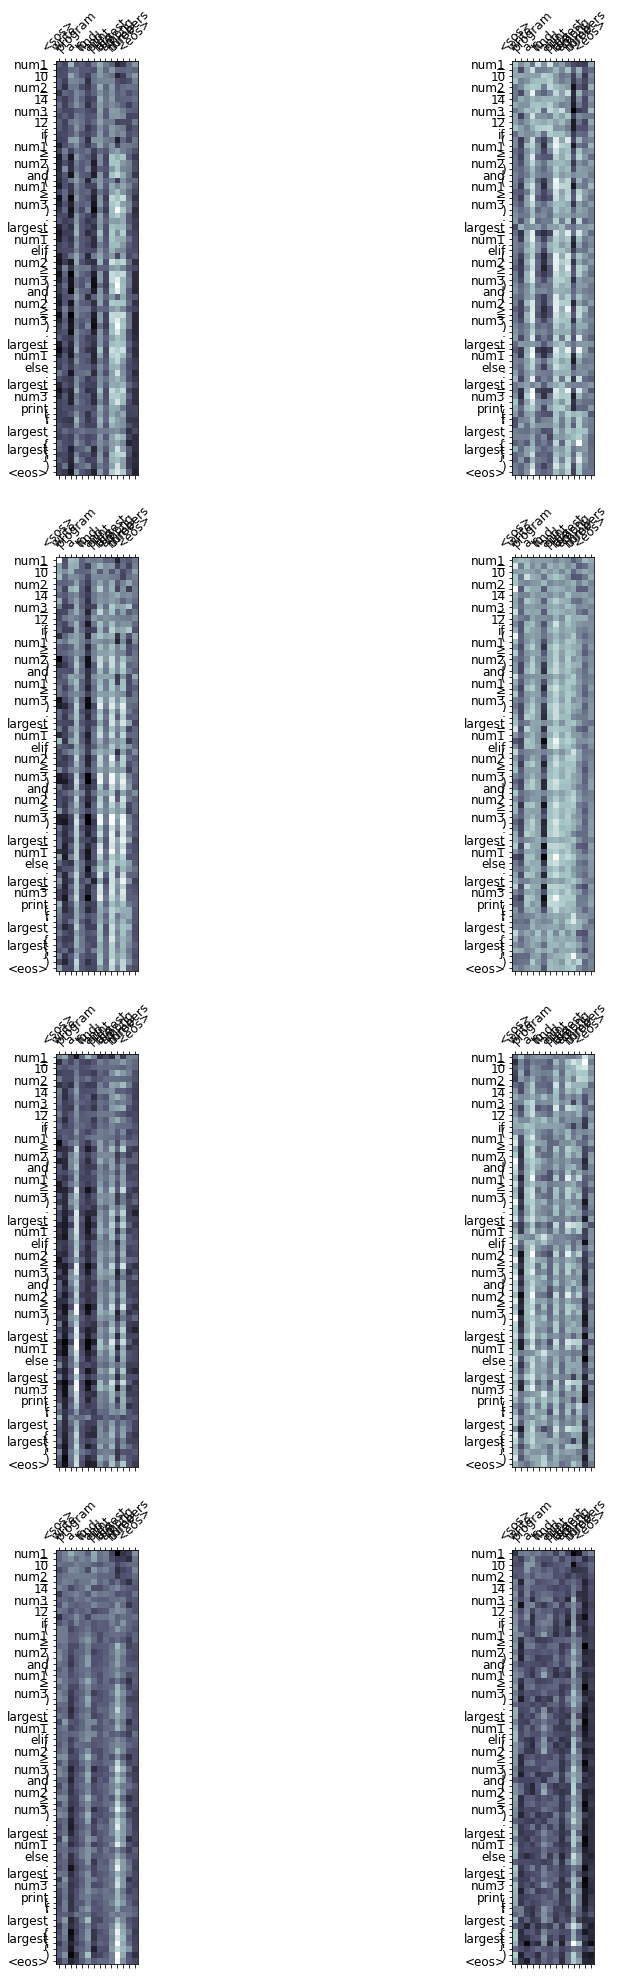

In [ ]:
sentence = "write a program to find and print the largest among three numbers"
code, attention = translate_sentence(sentence, SRC, TRG, model, device)
print(f'predicted trg = {code}')
#print(f'predicted trg = {" ".join(code)}')
display_attention(sentence, code, attention)


num1=10
num2=14
num3=12
if(num1>=num2)and(num1>=num3):
    largest=num1
elif(num2>=num3)and(num2>=num3):
    largest=num1
else:
    largest=num3
print(f'largest:{largest}')<eos>


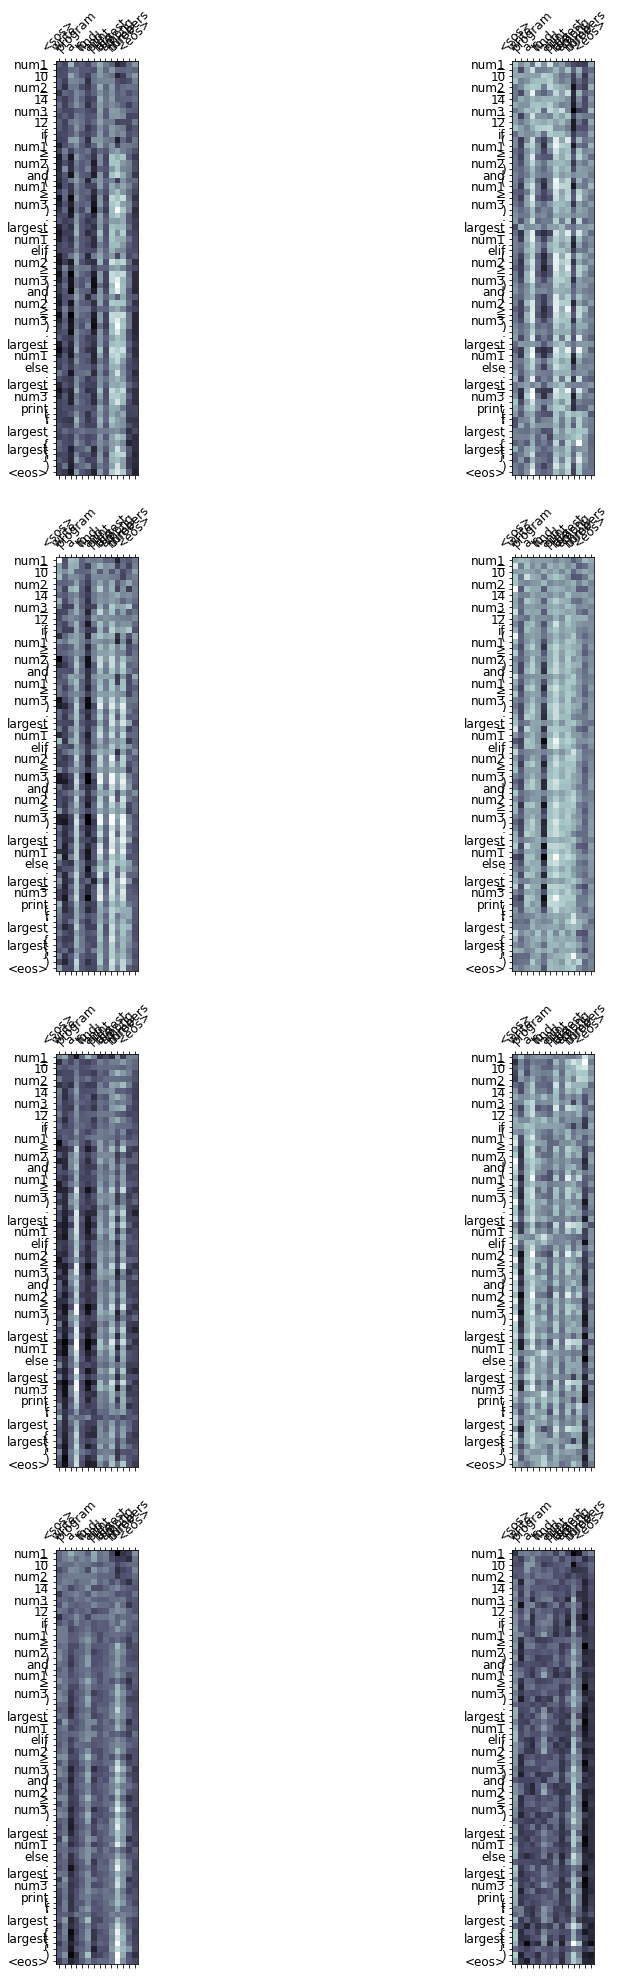

In [ ]:
print("".join(code))
display_attention(sentence, code, attention)

In [ ]:
sentence = "write a program to add two numbers"
code, attention = translate_sentence(sentence, SRC, TRG, model, device)
print(f'predicted trg = {code}')
print(f'predicted trg = {" ".join(code)}')
#display_attention(sentence, code, attention)


predicted trg = ['\n', 'num1', '=', '1', '.', '5', '\n', 'num2', '=', '6', '.', '3', '\n', 'sum', '=', 'num1', '+', 'num2', '\n', 'print', '(', 'f', "'", 'Sum', ':', '{', 'sum', '}', "'", ')', '<eos>']
predicted trg = 
 num1 = 1 . 5 
 num2 = 6 . 3 
 sum = num1 + num2 
 print ( f ' Sum : { sum } ' ) <eos>


In [ ]:
sentence = "write a program to multiply two numbers"
code,attention = translate_sentence(sentence, SRC, TRG, model, device)
print(f'predicted trg = {code}\n')
print(" ".join(code))
#display_attention(sentence, code, attention)

predicted trg = ['\n', 'num1', '=', '1', '.', '5', '\n', 'num2', '=', '6', '.', '3', '\n', 'sum', '=', 'num1', '*', 'num2', '\n', 'print', '(', 'f', "'", 'Product', ':', '{', 'sum', '}', "'", ')', '<eos>']


 num1 = 1 . 5 
 num2 = 6 . 3 
 sum = num1 * num2 
 print ( f ' Product : { sum } ' ) <eos>


predicted trg = ['num', '=', 'int', '(', 'input', '(', '"', 'Enter', 'a', 'number', ':', '"', ')', ')', '\n', 'factorial', '=', '1', '\n', 'if', 'num', '<', '0', ':', '\n    ', 'print', '(', '"', 'Sorry', ',', 'factorial', 'does', 'not', 'exist', 'for', 'negative', 'numbers', '"', ')', '\n', 'elif', 'num', '=', '=', '0', ':', '\n    ', 'print', '(', '"', 'The', 'factorial', 'of', '0', 'is', '1', '"', ')', '\n', 'else', ':', '\n    ', 'for', 'i', 'in', 'range', '(', '1', ',', 'num', '+', '1', ')', ':', '\n        ', 'factorial', '=', 'factorial', '*', 'i', '\n    ', 'print', '(', '"', 'The', 'factorial', 'of', '"', ',', 'num', ',', '"', 'is', '"', ',', 'factorial', ')', '<eos>']

num = int ( input ( " Enter a number : " ) ) 
 factorial = 1 
 if num < 0 : 
     print ( " Sorry , factorial does not exist for negative numbers " ) 
 elif num = = 0 : 
     print ( " The factorial of 0 is 1 " ) 
 else : 
     for i in range ( 1 , num + 1 ) : 
         factorial = factorial * i 
     print ( "

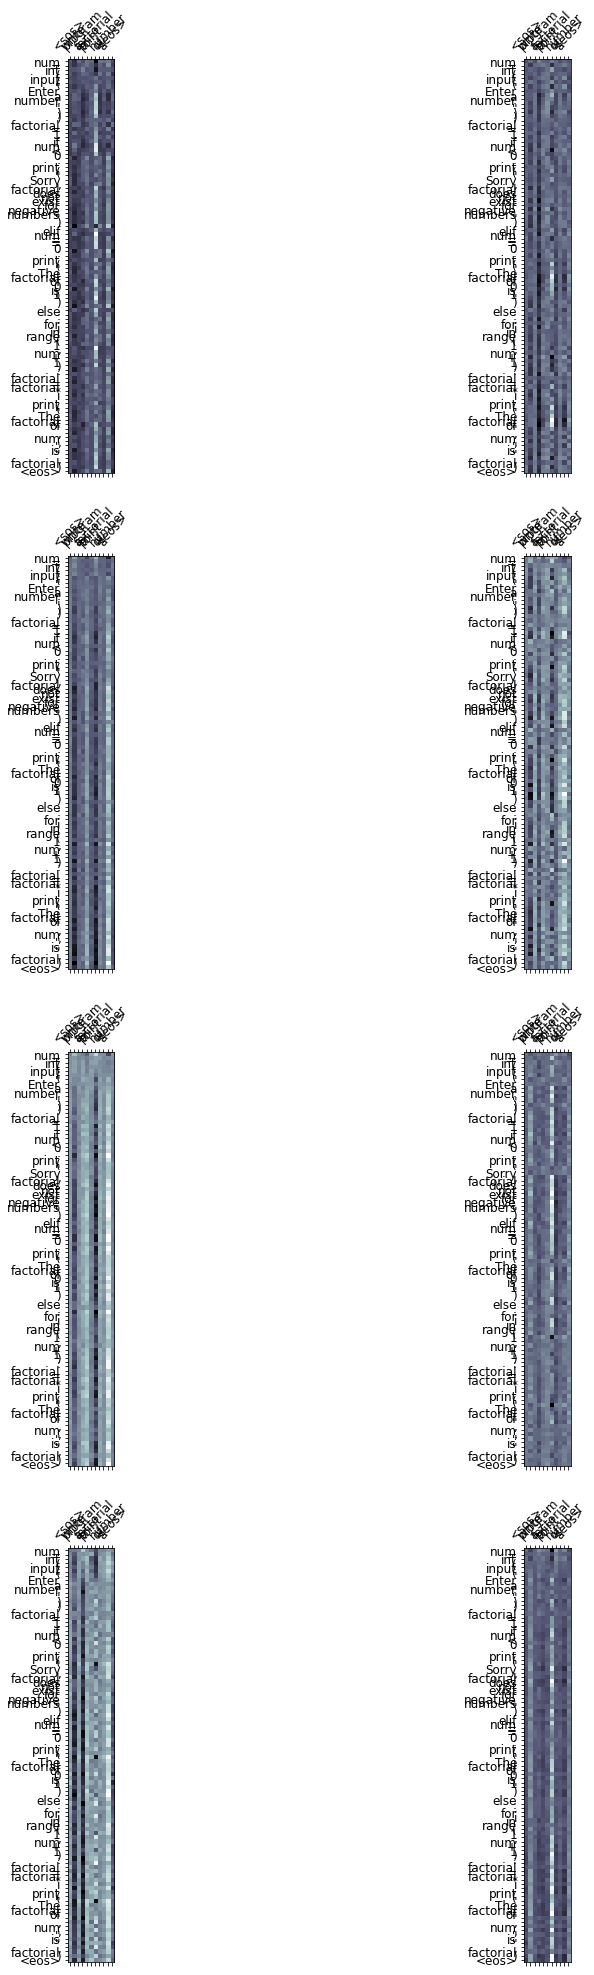

In [ ]:
sentence = "write a program to print factorial of a number"
code,attention = translate_sentence(sentence, SRC, TRG, model, device)
print(f'predicted trg = {code}\n')
print(" ".join(code))
display_attention(sentence, code, attention)

In [ ]:
import random
#Generate 5 random numbers between 10 and 30
randomlist = random.sample(range(0, len(test_data)), 25)
for ele in randomlist:
  example_idx = ele
  src = vars(test_data.examples[example_idx])['Description']
  trg = vars(test_data.examples[example_idx])['Code']
  # print(f'src = {src}')
  listToStr = ' '.join([str(elem) for elem in src]) 
  print(f'Question: {listToStr}')

  listToStr = ' '.join([str(elem) for elem in trg]) 
  print(f'Source Python:\n{listToStr}')
  
  print(f'\n')
  # print(f'\n')
  # print(f'trg = {trg}')
  listToStr = ' '.join([str(elem) for elem in trg]) 
  translation, attention = translate_sentence(src, SRC, TRG, model, device)
  listToStr = ' '.join([str(elem) for elem in translation]) 
  listToStrx = listToStr.replace('<eos>', '')
  print(f'Target Python:\n{listToStrx}')
  print('#########################################################################################################')
  print('#########################################################################################################')

Question: write a python program using list comprehension to produce and print the list [ [ 2 , 3 , 4 , 5 ] , [ 3 , 4 , 5 , 6 ] , [ 4 , 5 , 6 , 7 ] , [ 5 , 6 , 7 , 8 ] ]
Source Python:

 start_num = 2 
 repeat_count = 4 
 max_offset = 4 
 list5 = [ [ start_num + i + j for j in range ( max_offset ) ] 
                                          for i in range ( repeat_count ) ] 
 print ( list5 )


Target Python:

 start_num = 3 
 repeat_count = 3 
 max_offset = [ start_num + i + j ] 
     for j in range ( max_offset ) for i in range ( repeat_count ) ] 
 print ( <unk> ) 
#########################################################################################################
#########################################################################################################
Question: write a python program to read a file and capitalize the first letter of every word in the file
Source Python:
fname = input ( " Enter file name : " ) 
 with open ( fname , ' r ' ) as f : 
     for line i